# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql import types as t
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# df = spark.read.json("data/sparkify_log_small.json")
df = spark.read.json("mini_sparkify_event_data.json")

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [23]:
# the size of the dataset
print((df.count(), len(df.columns)))

(286500, 18)


In [21]:
# explore nulls
df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0--------------
 artist        | 58392 
 auth          | 0     
 firstName     | 8346  
 gender        | 8346  
 itemInSession | 0     
 lastName      | 8346  
 length        | 58392 
 level         | 0     
 location      | 8346  
 method        | 0     
 page          | 0     
 registration  | 8346  
 sessionId     | 0     
 song          | 58392 
 status        | 0     
 ts            | 0     
 userAgent     | 8346  
 userId        | 0     



# Exploratory Data Analysis¶

When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [7]:
# this is interesting, this user plays 8 songs in a row and then switches to auth: 'cancelled' after an advertisement
df.filter(df.userId==125).orderBy(F.col('ts')).show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|          location|method|                page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------------------+-------------+---------+--------------------+------+-------------+--------------------+------+
| Christopher O'Riley|Logged In|    Mason|     M|            0|    Hart|337.91955| free|Corpus Christi, TX|   PUT|            NextSong|1533157139000|      174|    paranoid android|   200|1539317144000|"Mozilla/5.0 (Mac...|   125|
|The Notorious B.I.G.|Logged In|    Mason|     M|            1|    Hart|230.0338

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [4]:
# this is a binary, indicator column to be used to predict churn
# may also look at incorporating 'downgrade'
df = df.withColumn(
    'churn',
    F.when((F.col('page') =='Cancellation Confirmation'), 1) \
    .otherwise(0)
)

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [10]:
# users who have a cancellation value of 1
users_who_quit = df.filter(df.churn==1) \
    .select(df.userId) \
    .dropDuplicates()

# users who have a cancellation value of 0
users_who_stayed = df.filter(df.churn==0) \
    .select(df.userId) \
    .dropDuplicates()

# examine their lengths
users_who_quit.count(), users_who_stayed.count(), ( users_who_quit.count() / (users_who_quit.count() + users_who_stayed.count())) * 100

(52, 226, 0.18705035971223022)

In [11]:
# are cancellation rates the same between free and paid users? 
churn_table = df.select(df.level, df.churn, df.userId) \
    .dropDuplicates() \
    .groupBy(F.col('level'),F.col('churn')) \
    .count() \
    .withColumnRenamed('count','user_count')

churn_table.show()

+-----+-----+----------+
|level|churn|user_count|
+-----+-----+----------+
| paid|    0|       166|
| free|    0|       196|
| paid|    1|        31|
| free|    1|        21|
+-----+-----+----------+



In [90]:
# 16% of paid and 10% of free users churned
( 31 / ( 166 + 31)) * 100, ( 21 / ( 196 + 21)) * 100

(15.736040609137056, 9.67741935483871)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [63]:
# ideas
# split the 'location' field into 'city' and 'state' fields
# split the 'userAgent' field into 'browser' and 'OS' fields
# calculate CurrentSessionItem - SessionItem@Advert ... is there a relationship between advertisements and cancelling?
# although advertisements only apply to free users, I guess

In [5]:
# create browser, os, brand from userAgent
df = df.withColumn('browser', F.split(df['userAgent'], '\(').getItem(0)) \
    .withColumn('temp', F.split(df['userAgent'], '\(').getItem(1)) 

df = df.withColumn('os', F.split(df['temp'], ';').getItem(0)) \
    .withColumn('brand', F.split(df['temp'], ';').getItem(1))

# delete temp, userAgent

In [6]:
# split the 'location' field into 'city' and 'state fields'
df = df.withColumn('city', F.split(df['location'], ',').getItem(0)) \
    .withColumn('state', F.split(df['location'], ',').getItem(1))

# delete location

In [7]:
# create window partition
w = Window.partitionBy("userId").orderBy("sessionId")
# calculate lag
df = df.withColumn("lead", F.lag('ts', 1).over(w)) \
    .withColumn("tsDiff", ( F.col('ts') - F.col('lead')) / 1000)

In [38]:
# show distinct values for each column and display vertically
df.agg(*(F.countDistinct(c).alias(c) for c in df.columns)).show(vertical=True)

-RECORD 0---------------
 userId        | 226    
 artist        | 17655  
 auth          | 4      
 firstName     | 189    
 gender        | 2      
 itemInSession | 1322   
 lastName      | 173    
 length        | 14865  
 level         | 2      
 location      | 114    
 method        | 2      
 page          | 22     
 registration  | 225    
 sessionId     | 2354   
 song          | 58480  
 status        | 3      
 ts            | 277447 
 userAgent     | 56     
 churn         | 2      
 browser       | 2      
 temp          | 43     
 os            | 11     
 brand         | 30     
 city          | 113    
 state         | 58     
 min_user_ts   | 226    
 rel_user_ts   | 275518 
 min_ts        | 1      
 rel_ts        | 277447 



## Work-in-Progress

In [29]:
# somehow incorporate the order of pages visited as a feature
# or categorize the pages as 'positive interaction' or 'negative interaction'
df.filter(df.page != "Cancellation Confirmation") \
    .select("userId","page","itemInSession") \
    .groupBy("userId","page") \
    .agg(F.max("itemInSession").alias("maxItem")) \
    .orderBy("userId","maxItem") \
    .show(30)

+------+-------------------+-------+
|userId|               page|maxItem|
+------+-------------------+-------+
|      |Submit Registration|      8|
|      |           Register|     40|
|      |              Error|    216|
|      |               Help|    518|
|      |              About|    862|
|      |               Home|   1287|
|      |              Login|   1288|
|    10|               Help|     14|
|    10|        Roll Advert|     22|
|    10|      Save Settings|     80|
|    10|          Downgrade|    306|
|    10|    Add to Playlist|    400|
|    10|         Add Friend|    405|
|    10|             Logout|    406|
|    10|          Thumbs Up|    421|
|    10|               Home|    434|
|    10|        Thumbs Down|    451|
|    10|           NextSong|    454|
|    10|           Settings|    455|
|    10|              About|    456|
|   100|            Upgrade|     55|
|   100|      Save Settings|     55|
|   100|     Submit Upgrade|     56|
|   100|           Settings|    158|
|

## Create Pivots for Feature Engineering

In [8]:
# create churn table
user_churn_df = df.select("userId","churn").groupBy("userId").sum("churn").withColumnRenamed("sum(churn)","churn")

In [9]:
# create page table
user_page_df = df.select("userId","page","tsDiff") \
    .filter(df.page != "Cancellation Confirmation") \
    .filter(df.page != "Cancel") \
    .groupBy("userId") \
    .pivot("page") \
    .avg("tsDiff")

In [10]:
# create level table
user_level = df.select("userId","level","sessionId") \
    .groupBy("userId") \
    .pivot("level") \
    .count()

user_level = user_level.select(F.col("userId"), F.col("free").cast(t.DoubleType()), F.col("paid").cast(t.DoubleType()))

In [11]:
# create location table
user_location = df.select("userId","city","state","browser","os","brand") \
    .dropDuplicates()

In [12]:
# join all the tables together
user_data = user_churn_df.join(user_page_df, ['userId'], "left") \
    .join(user_level, ['userId'], "left") \
    .join(user_location, ['userId'], "left") \
    .drop("userId")

In [13]:
user_data.show(5, vertical=True)

-RECORD 0-----------------------------------
 churn               | 0                    
 About               | 36.0                 
 Add Friend          | 1.0                  
 Add to Playlist     | 14.714285714285714   
 Downgrade           | null                 
 Error               | null                 
 Help                | 22.0                 
 Home                | 136272.0909090909    
 Login               | null                 
 Logout              | 1.0                  
 NextSong            | 8467.649635036496    
 Register            | null                 
 Roll Advert         | 20.28846153846154    
 Save Settings       | null                 
 Settings            | null                 
 Submit Downgrade    | null                 
 Submit Registration | null                 
 Submit Upgrade      | null                 
 Thumbs Down         | 1.0                  
 Thumbs Up           | 1.0                  
 Upgrade             | 10.0                 
 free     

In [16]:
# for all null values in categorical variables, 
# set as missing
# this is outside of the pipeline because imputer cannot
# handle categorical variables
user_data = user_data.fillna({'city':'missing', 'state':'missing', 'browser':'missing', 'os':'missing','brand':'missing'})

In [15]:
user_data = user_data.fillna({
    'churn':0, 'About':0, 'Add Friend':0, 'Add to Playlist':0, 'Downgrade':0, 'Error':0, 
    'Help':0, 'Home':0, 'Login':0, 'Logout':0, 'NextSong':0, 'Register':0, 'Roll Advert':0, 
    'Save Settings': 0, 'Settings':0, 'Submit Downgrade':0, 'Submit Registration':0, 'Submit Upgrade':0, 
    'Thumbs Down':0, 'Thumbs Up':0, 'Upgrade':0, 'free':0, 'paid':0})

In [17]:
# apparently 'churn' should be named 'label'
user_data = user_data.withColumnRenamed("churn","label")

In [18]:
user_data.show(5, vertical=True)

-RECORD 0-----------------------------------
 label               | 0                    
 About               | 36.0                 
 Add Friend          | 1.0                  
 Add to Playlist     | 14.714285714285714   
 Downgrade           | 0.0                  
 Error               | 0.0                  
 Help                | 22.0                 
 Home                | 136272.0909090909    
 Login               | 0.0                  
 Logout              | 1.0                  
 NextSong            | 8467.649635036496    
 Register            | 0.0                  
 Roll Advert         | 20.28846153846154    
 Save Settings       | 0.0                  
 Settings            | 0.0                  
 Submit Downgrade    | 0.0                  
 Submit Registration | 0.0                  
 Submit Upgrade      | 0.0                  
 Thumbs Down         | 1.0                  
 Thumbs Up           | 1.0                  
 Upgrade             | 10.0                 
 free     

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Columns Used: 

In [76]:
user_data.printSchema()

root
 |-- label: long (nullable = true)
 |-- About: double (nullable = true)
 |-- Add Friend: double (nullable = true)
 |-- Add to Playlist: double (nullable = true)
 |-- Downgrade: double (nullable = true)
 |-- Error: double (nullable = true)
 |-- Help: double (nullable = true)
 |-- Home: double (nullable = true)
 |-- Login: double (nullable = true)
 |-- Logout: double (nullable = true)
 |-- NextSong: double (nullable = true)
 |-- Register: double (nullable = true)
 |-- Roll Advert: double (nullable = true)
 |-- Save Settings: double (nullable = true)
 |-- Settings: double (nullable = true)
 |-- Submit Downgrade: double (nullable = true)
 |-- Submit Registration: double (nullable = true)
 |-- Submit Upgrade: double (nullable = true)
 |-- Thumbs Down: double (nullable = true)
 |-- Thumbs Up: double (nullable = true)
 |-- Upgrade: double (nullable = true)
 |-- free: double (nullable = true)
 |-- paid: double (nullable = true)
 |-- city: string (nullable = false)
 |-- state: string (null

In [15]:
print(user_data.count())

226


In [26]:
categ_pipeline = Pipeline(stages=[
    StringIndexer(inputCol="city",outputCol="cityIndex", handleInvalid="skip"),
    StringIndexer(inputCol="state",outputCol="stateIndex", handleInvalid="skip"),
    StringIndexer(inputCol="browser",outputCol="osIndex", handleInvalid="skip"),
    StringIndexer(inputCol="os",outputCol="browserIndex", handleInvalid="skip"),
    StringIndexer(inputCol="brand",outputCol="brandIndex", handleInvalid="skip"),
    VectorAssembler(
        inputCols=["cityIndex","stateIndex","osIndex","browserIndex","brandIndex"], 
        outputCol="categ_features"
    )
])

In [27]:
# create list of numeric columns
numeric_cols = user_page_df.columns[1:] + user_level.columns[1:]
out_numeric_cols = [ n + '_imp' for n in numeric_cols ]
# create pipeline
numer_pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=numeric_cols, outputCol="numer_features")
])

In [28]:
# unite pipelines
final_pipeline = Pipeline(stages=[
    categ_pipeline,
    numer_pipeline,
    VectorAssembler(
        inputCols=["categ_features","numer_features"],
        outputCol="features"
    ),
    LogisticRegression(maxIter=10)
])

In [57]:
#fit the pipeline to our dataframe
pipelineModel = final_pipeline.fit(user_data)
#transform the dataframe
# transformed_data = pipelineModel.transform(user_data)

In [71]:
pipelineModel.stages[-1].summary.accuracy

0.7787610619469026

In [72]:
pipelineModel.stages[-1].summary.areaUnderROC

0.7668545534924848

In [77]:
# save roc data
roc_df = pipelineModel.stages[-1].summary.roc
# convert to pandas

In [78]:
import pandas as pd
pandasDF = roc_df.toPandas()
# create scatterplot

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/opt/spark-2.4.3-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'VectorAssembler' object has no attribute '_java_obj'
Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/opt/spark-2.4.3-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'StringIndexer' object has no attribute '_java_obj'


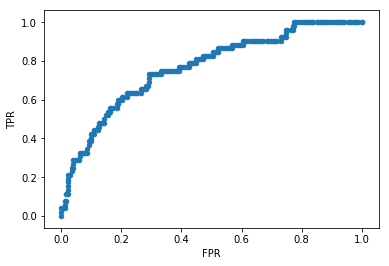

In [81]:
%matplotlib inline
pandasDF.plot.scatter(x='FPR',y='TPR')

In [73]:
# there definitely seems to be a browser issue
print("coefficients: " + str(pipelineModel.stages[-1].coefficientMatrix))

coefficients: DenseMatrix([[  1.39444872e-03,   4.16220274e-03,   2.51712723e-01,
               -2.95805071e-03,  -3.08518978e-02,  -8.67307251e-06,
                0.00000000e+00,   1.10857386e-03,   1.28076442e-03,
               -1.83401657e-05,   9.02829945e-06,  -3.51325582e-06,
                0.00000000e+00,   0.00000000e+00,  -1.72127888e-04,
                0.00000000e+00,   7.54878010e-04,   0.00000000e+00,
               -2.39129778e-03,   0.00000000e+00,   0.00000000e+00,
                0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
                1.20896507e-03,  -4.24891630e-04,  -6.02705120e-04]])


# Cross-Validate

In [23]:
paramGrid = ParamGridBuilder() \
    .addGrid(LogisticRegression.regParam, [0.1, 0.05, 0.01]) \
    .build()

In [32]:
crossval = CrossValidator(estimator=final_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC'),
                          numFolds=5) 

In [33]:
cvModel = crossval.fit(user_data)

In [34]:
# certainly looks like the regParam is fine at 0.1
cvModel.avgMetrics

[0.7880498487020224, 0.7880498487020224, 0.7880498487020224]

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.